In [ ]:
%matplotlib inline
import os,random
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py    
import numpy as np   
from torchsummary import summary

# Check if dataset is present
import os.path

The dataset is available here: https://opendata.deepsig.io/datasets/2018.01/2018.01.OSC.0001_1024x2M.h5.tar.gz

In [ ]:
dataset_path = ".../2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"

print(os.path.isfile(dataset_path))

print(torch.version.cuda)
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

True
11.0
Using GPU 0


In [48]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_18_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        sub_train_indices=[]
        sub_test_indices=[]
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                sub_split_train=int(np.ceil(0.1 * split))
                sub_split_test=int(np.ceil(0.9 * split))
                sub_train_indices_subclass = indices_subclass[sub_split_train:split]
                sub_test_indices_subclass = indices_subclass[split:451]
                
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                    sub_train_indices.extend(sub_train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                sub_test_indices.extend(sub_test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
        
        self.sub_train_sampler = torch.utils.data.SubsetRandomSampler(sub_train_indices)
        self.sub_test_sampler = torch.utils.data.SubsetRandomSampler(sub_test_indices)
    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_18_dataset(dataset_path)

Modulation: 16QAM, SNR: 30.0 dB, Index: 1380475


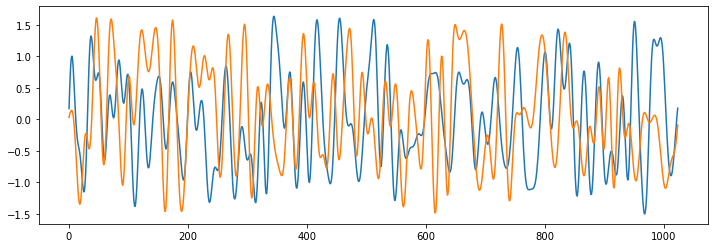

In [49]:
# Inspect a frame
mod = 12 # 0 to 23
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))

In [50]:
from torch import nn

from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Batches", leave=False):   
        if gpu is not None:
            inputs = inputs.cuda()
            target = target.cuda()
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in test_loader:
            if gpu is not None:
                inputs = inputs.cuda()
                target = target.cuda()
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
          

In [51]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Adjustable hyperparameters
input_bits = 8

a_bits = 8



w_bits = 8
w1_bits = 8

# filters_conv = 64
# filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    bit_width = input_bits
    min_val = -2.0
    max_val = 2.0
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class model(nn.Sequential):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = qnn.QuantConv1d(2, 64, 3, padding=1, weight_bit_width=6, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol1 = nn.MaxPool1d(2)

        self.conv2 = qnn.QuantConv1d(64, 64, 3, padding=1, weight_bit_width=2, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol2 = nn.MaxPool1d(2)

        self.conv3 = qnn.QuantConv1d(64, 64, 3, padding=1, weight_bit_width=4, bias=False)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol3 = nn.MaxPool1d(2)
        
        self.conv4 = qnn.QuantConv1d(64, 64, 3, padding=1, weight_bit_width=4, bias=False)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol4 = nn.MaxPool1d(2)
        
        self.conv5 = qnn.QuantConv1d(64, 64, 3, padding=1, weight_bit_width=2, bias=False)
        self.bn5 = nn.BatchNorm1d(64)
        self.relu5 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol5 = nn.MaxPool1d(2)    

        self.conv6 = qnn.QuantConv1d(64, 64, 3, padding=1, weight_bit_width=6, bias=False)
        self.bn6 = nn.BatchNorm1d(64)
        self.relu6 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol6 = nn.MaxPool1d(2)

        self.conv7 = qnn.QuantConv1d(64, 64, 3, padding=1, weight_bit_width=6, bias=False)
        self.bn7 = nn.BatchNorm1d(64)
        self.relu7 = qnn.QuantReLU(bit_width=a_bits)
        self.maxpol7 = nn.MaxPool1d(2)
        
        self.Flatten = nn.Flatten()
        self.linear1 =  qnn.QuantLinear(512,128, weight_bit_width=2, bias=False)
        self.BatchNorm1d1 =  nn.BatchNorm1d(128)
        self.reluLinear1 = qnn.QuantReLU(bit_width=a_bits)
        
        self.linear2 =  qnn.QuantLinear(128,128, weight_bit_width=4, bias=False)
        self.BatchNorm1d2 =  nn.BatchNorm1d(128)
        self.reluLinear2 = qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True)
        
        self.linear3  = qnn.QuantLinear(128, 24, weight_bit_width=3, bias=True, bias_quant=IntBias)
        
    def forward(self, input):
#         ks = 2
        qnn.QuantHardTanh(act_quant=InputQuantizer)
#         x = F.avg_pool1d(input, kernel_size=2, stride=2)
        output = self.maxpol1(self.relu1(self.bn1(self.conv1(input))))  
        output = self.maxpol2(self.relu2(self.bn2(self.conv2(output))))
        output = self.maxpol3(self.relu3(self.bn3(self.conv3(output))))
        output = self.maxpol4(self.relu4(self.bn4(self.conv4(output))))
        output = self.maxpol5(self.relu5(self.bn5(self.conv5(output))))
        output = self.maxpol6(self.relu6(self.bn6(self.conv6(output))))
        output = self.maxpol7(self.relu7(self.bn7(self.conv7(output))))
        output = self.Flatten(output)
#         print(output.shape)  # consult shape
        output = self.reluLinear1(self.BatchNorm1d1(self.linear1(output)))
        output = self.reluLinear2(self.BatchNorm1d2(self.linear2(output)))
        output = self.linear3(output)      
        return output

    


In [53]:
batch_size = 512
num_epochs = 60

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.sub_train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.sub_test_sampler)

if gpu is not None:
    model = model().cuda()
# model = model().cpu()
# # loss criterion and optimizer

criterion = nn.CrossEntropyLoss()

if gpu is not None:
    criterion = criterion.cuda()
# criterion = criterion.cpu()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

running_loss = []
running_test_acc = []
test_acc_control=0
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        
        print("Epoch %d: Training loss = %f, test accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))
        if test_acc > test_acc_control:
            test_acc_control = test_acc
            models_path = ".../models/"
            torch.save(model.state_dict(), models_path+"model_train_avg_QUAN_best_6244266243.pth")
            
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()
        

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 0: Training loss = 1.976165, test accuracy = 0.191878


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1: Training loss = 1.731645, test accuracy = 0.354362


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 2: Training loss = 1.660449, test accuracy = 0.336460


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 3: Training loss = 1.584762, test accuracy = 0.407872


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 4: Training loss = 1.518591, test accuracy = 0.413266


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 5: Training loss = 1.598300, test accuracy = 0.259733


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 6: Training loss = 1.533022, test accuracy = 0.409787


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 7: Training loss = 1.487595, test accuracy = 0.393293


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 8: Training loss = 1.438450, test accuracy = 0.470020


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 9: Training loss = 1.399439, test accuracy = 0.494684


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 10: Training loss = 1.484812, test accuracy = 0.425070


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 11: Training loss = 1.453455, test accuracy = 0.468301


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 12: Training loss = 1.415254, test accuracy = 0.381801


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 13: Training loss = 1.379943, test accuracy = 0.469786


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 14: Training loss = 1.337490, test accuracy = 0.496795


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 15: Training loss = 1.426778, test accuracy = 0.447272


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 16: Training loss = 1.403557, test accuracy = 0.441291


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 17: Training loss = 1.367983, test accuracy = 0.441800


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 18: Training loss = 1.336113, test accuracy = 0.505316


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 19: Training loss = 1.303981, test accuracy = 0.518175


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 20: Training loss = 1.388133, test accuracy = 0.449187


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 21: Training loss = 1.386652, test accuracy = 0.468652


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 22: Training loss = 1.345216, test accuracy = 0.491010


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 23: Training loss = 1.310292, test accuracy = 0.496130


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 24: Training loss = 1.280669, test accuracy = 0.511218


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 25: Training loss = 1.371561, test accuracy = 0.473694


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 26: Training loss = 1.348240, test accuracy = 0.507075


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 27: Training loss = 1.319822, test accuracy = 0.466503


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 28: Training loss = 1.290475, test accuracy = 0.517472


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 29: Training loss = 1.261208, test accuracy = 0.519973


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 30: Training loss = 1.342772, test accuracy = 0.499375


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 31: Training loss = 1.332706, test accuracy = 0.475805


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 32: Training loss = 1.304358, test accuracy = 0.490541


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 33: Training loss = 1.276967, test accuracy = 0.511335


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 34: Training loss = 1.248627, test accuracy = 0.534045


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 35: Training loss = 1.333477, test accuracy = 0.476001


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 36: Training loss = 1.315351, test accuracy = 0.450868


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 37: Training loss = 1.288823, test accuracy = 0.484795


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 38: Training loss = 1.263648, test accuracy = 0.483427


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 39: Training loss = 1.236301, test accuracy = 0.516729


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 40: Training loss = 1.318271, test accuracy = 0.524664


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 41: Training loss = 1.308195, test accuracy = 0.491401


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 42: Training loss = 1.284064, test accuracy = 0.499218


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 43: Training loss = 1.253923, test accuracy = 0.475492


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 44: Training loss = 1.227371, test accuracy = 0.527478


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 45: Training loss = 1.305130, test accuracy = 0.479479


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 46: Training loss = 1.296035, test accuracy = 0.466307


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 47: Training loss = 1.272778, test accuracy = 0.484092


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 48: Training loss = 1.246512, test accuracy = 0.514462


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 49: Training loss = 1.220213, test accuracy = 0.517042


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 50: Training loss = 1.295294, test accuracy = 0.492026


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 51: Training loss = 1.285380, test accuracy = 0.511257


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 52: Training loss = 1.265180, test accuracy = 0.503283


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 53: Training loss = 1.237245, test accuracy = 0.532051


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 54: Training loss = 1.211720, test accuracy = 0.523530


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 55: Training loss = 1.286800, test accuracy = 0.479714


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 56: Training loss = 1.279398, test accuracy = 0.467402


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 57: Training loss = 1.254714, test accuracy = 0.471545


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 58: Training loss = 1.229182, test accuracy = 0.491870


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 59: Training loss = 1.204582, test accuracy = 0.541667


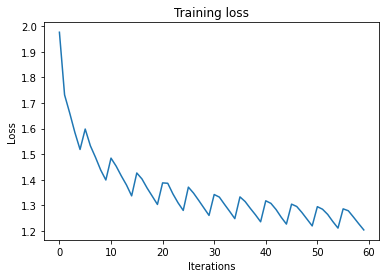

In [55]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

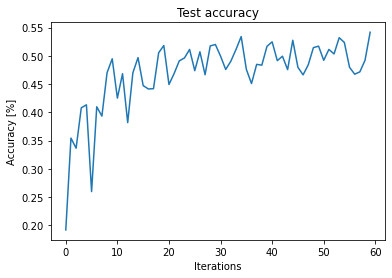

In [56]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [57]:
# #Load trained parameters
savefile = ".../model_train_avg_QUAN_best_6244266243.pth"
saved_state = torch.load(savefile, map_location=torch.device("cpu"))
model.load_state_dict(saved_state)
if gpu is not None:
    model = model.cuda()

In [58]:
# Set up a fresh test data loader
# batch_size = 2048
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.sub_test_sampler)

In [59]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Overall Accuracy across all SNRs: 0.541667


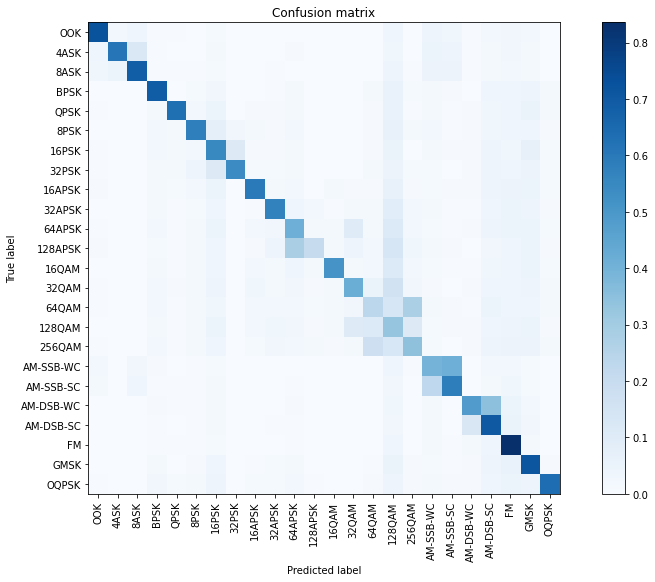

In [60]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# 
conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

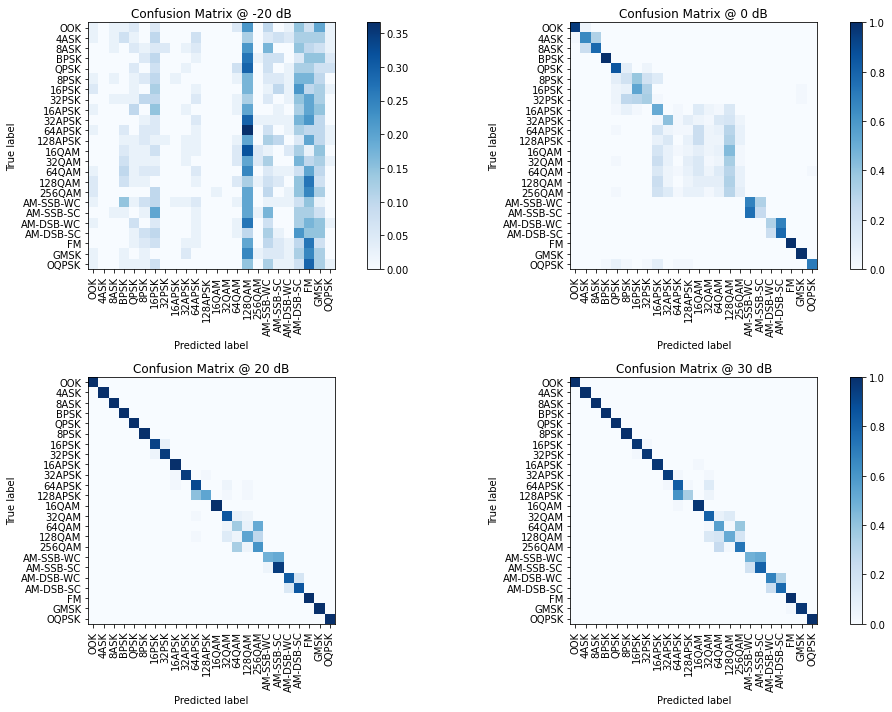

In [61]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20, 0,+20,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

Accuracy @ highest SNR (+30 dB): 0.848577
Accuracy overall: 0.541667


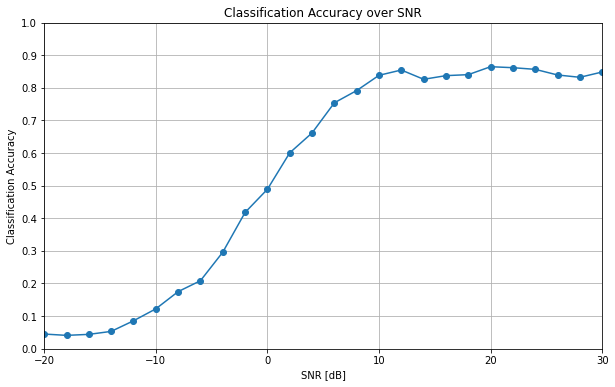

In [63]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

In [65]:
from brevitas.export.onnx.generic.manager import BrevitasONNXManager

export_onnx_path = ".../sandbox/notebooks/model_export.onnx"
final_onnx_path = ".../sandbox/notebooks/model_final.onnx"
cost_dict_path = "...in/sandbox/notebooks/model_cost.json"

BrevitasONNXManager.export(model.cpu(), input_t=torch.randn(1, 2, 1024), export_path=export_onnx_path);

In [66]:
from finn.util.inference_cost import inference_cost
import json

inference_cost(export_onnx_path, output_json=cost_dict_path, output_onnx=final_onnx_path,
               preprocess=True, discount_sparsity=True)

Inference cost for /home/david/Challenge_2021_version_24-07-2022/brevitas-radioml-challenge-21-main/sandbox/notebooks/model_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 130328.0,
  "mem_w_SCALEDINT2": 29287.0,
  "mem_w_SCALEDINT3": 2815.0,
  "mem_w_SCALEDINT4": 33166.0,
  "mem_w_SCALEDINT6": 23449.0,
  "op_mac_FLOAT32_SCALEDINT6": 382976.0,
  "op_mac_SCALEDUINT8_SCALEDINT2": 3249952.0,
  "op_mac_SCALEDUINT8_SCALEDINT3": 2815.0,
  "op_mac_SCALEDUINT8_SCALEDINT4": 3892843.0,
  "op_mac_SCALEDUINT8_SCALEDINT6": 551664.0,
  "total_bops": 276649032.0,
  "total_mem_o_bits": 4170496.0,
  "total_mem_w_bits": 340377.0,
  "unsupported": "set()"
}
